### SSR greedy algorithm
Stepwise sparse regression (SSR) solves the problem by iteratively truncating off the smallest coefficient during the optimization. There are many ways one can decide to truncate terms. We implement two popular ways, truncating the smallest coefficient at each iteration, or chopping each coefficient, computing N - 1 models, and then choosing the model with the lowest residual error. 

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.integrate import odeint
from sklearn.linear_model import Lasso
import pysindy as ps

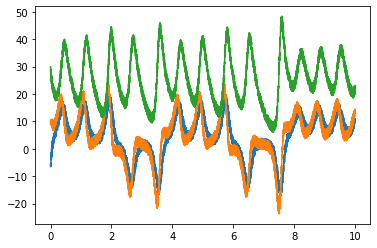

In [2]:
def lorenz(z, t):
    return [
        10 * (z[1] - z[0]),
        z[0] * (28 - z[2]) - z[1],
        z[0] * z[1] - (8 / 3) * z[2]
    ]

dt = .002
t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
x_train = x_train + np.random.rand(x_train.shape[0], 3) * 4
ssr_optimizer = ps.SSR(alpha=.05)

model = ps.SINDy(optimizer=ssr_optimizer)
model.fit(x_train, t=dt)

for i in range(3):
    plt.plot(t_train, x_train[:, i])

Note the usage is a bit different because we save all the sparse models and we choose our favorite one afterwards. Below we show Model 4 has the lowest MSE between the predicted and true derivative, so we could use this to choose our model. 

Model 0, MSE: 627.209646
Model 1, MSE: 610.155794
Model 2, MSE: 593.563372
Model 3, MSE: 615.647951
Model 4, MSE: 632.701965
Model 5, MSE: 651.208008
Model 6, MSE: 2425.746023
Model 7, MSE: 2425.129374


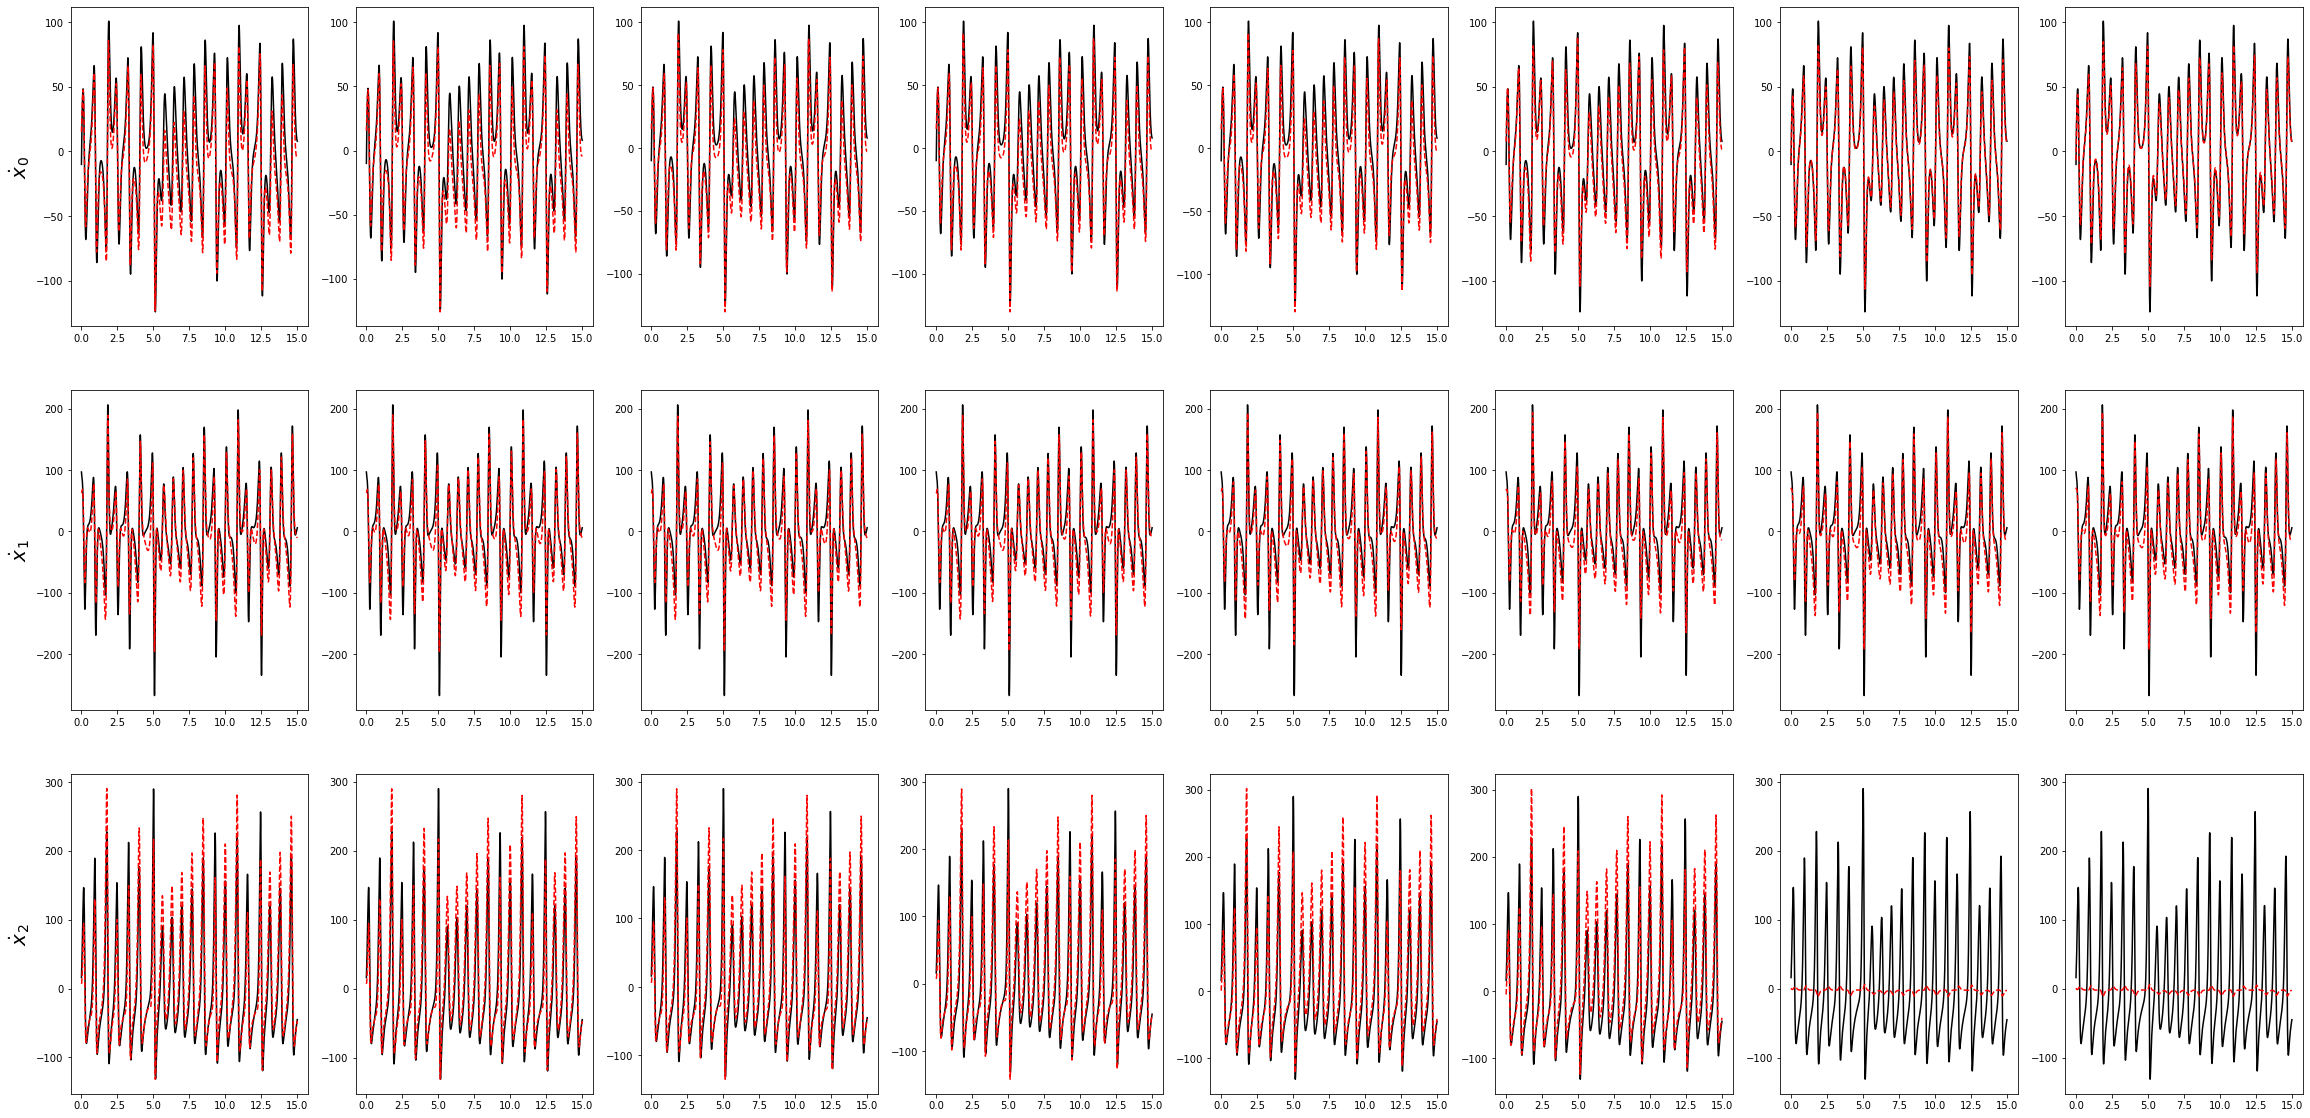

In [3]:
from sklearn.metrics import mean_squared_error

# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
x_test = odeint(lorenz, x0_test, t_test)  

plt.figure(figsize=(40, 20))
for j in range(np.shape(ssr_optimizer.history_)[0]):
    ssr_optimizer.coef_ = np.asarray(ssr_optimizer.history_)[j, :, :]
    
    # Predict derivatives using the learned model
    x_dot_test_predicted = model.predict(x_test)  

    # Compute derivatives with a finite difference method, for comparison
    x_dot_test_computed = model.differentiate(x_test, t=dt)

    for i in range(x_test.shape[1]):
        plt.subplot(np.shape(x_test)[1], np.shape(ssr_optimizer.history_)[0], 
                    i * np.shape(ssr_optimizer.history_)[0] + j + 1)
        plt.plot(t_test, x_dot_test_computed[:, i],
                    'k', label='numerical derivative')
        plt.plot(t_test, x_dot_test_predicted[:, i],
                    'r--', label='model prediction')
        if j == 0:
            plt.ylabel('$\dot x_{}$'.format(i), fontsize=20)
            
    print('Model ' + str(j) + ', MSE: %f' % model.score(x_test, t=dt, metric=mean_squared_error))

/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/usr/local/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


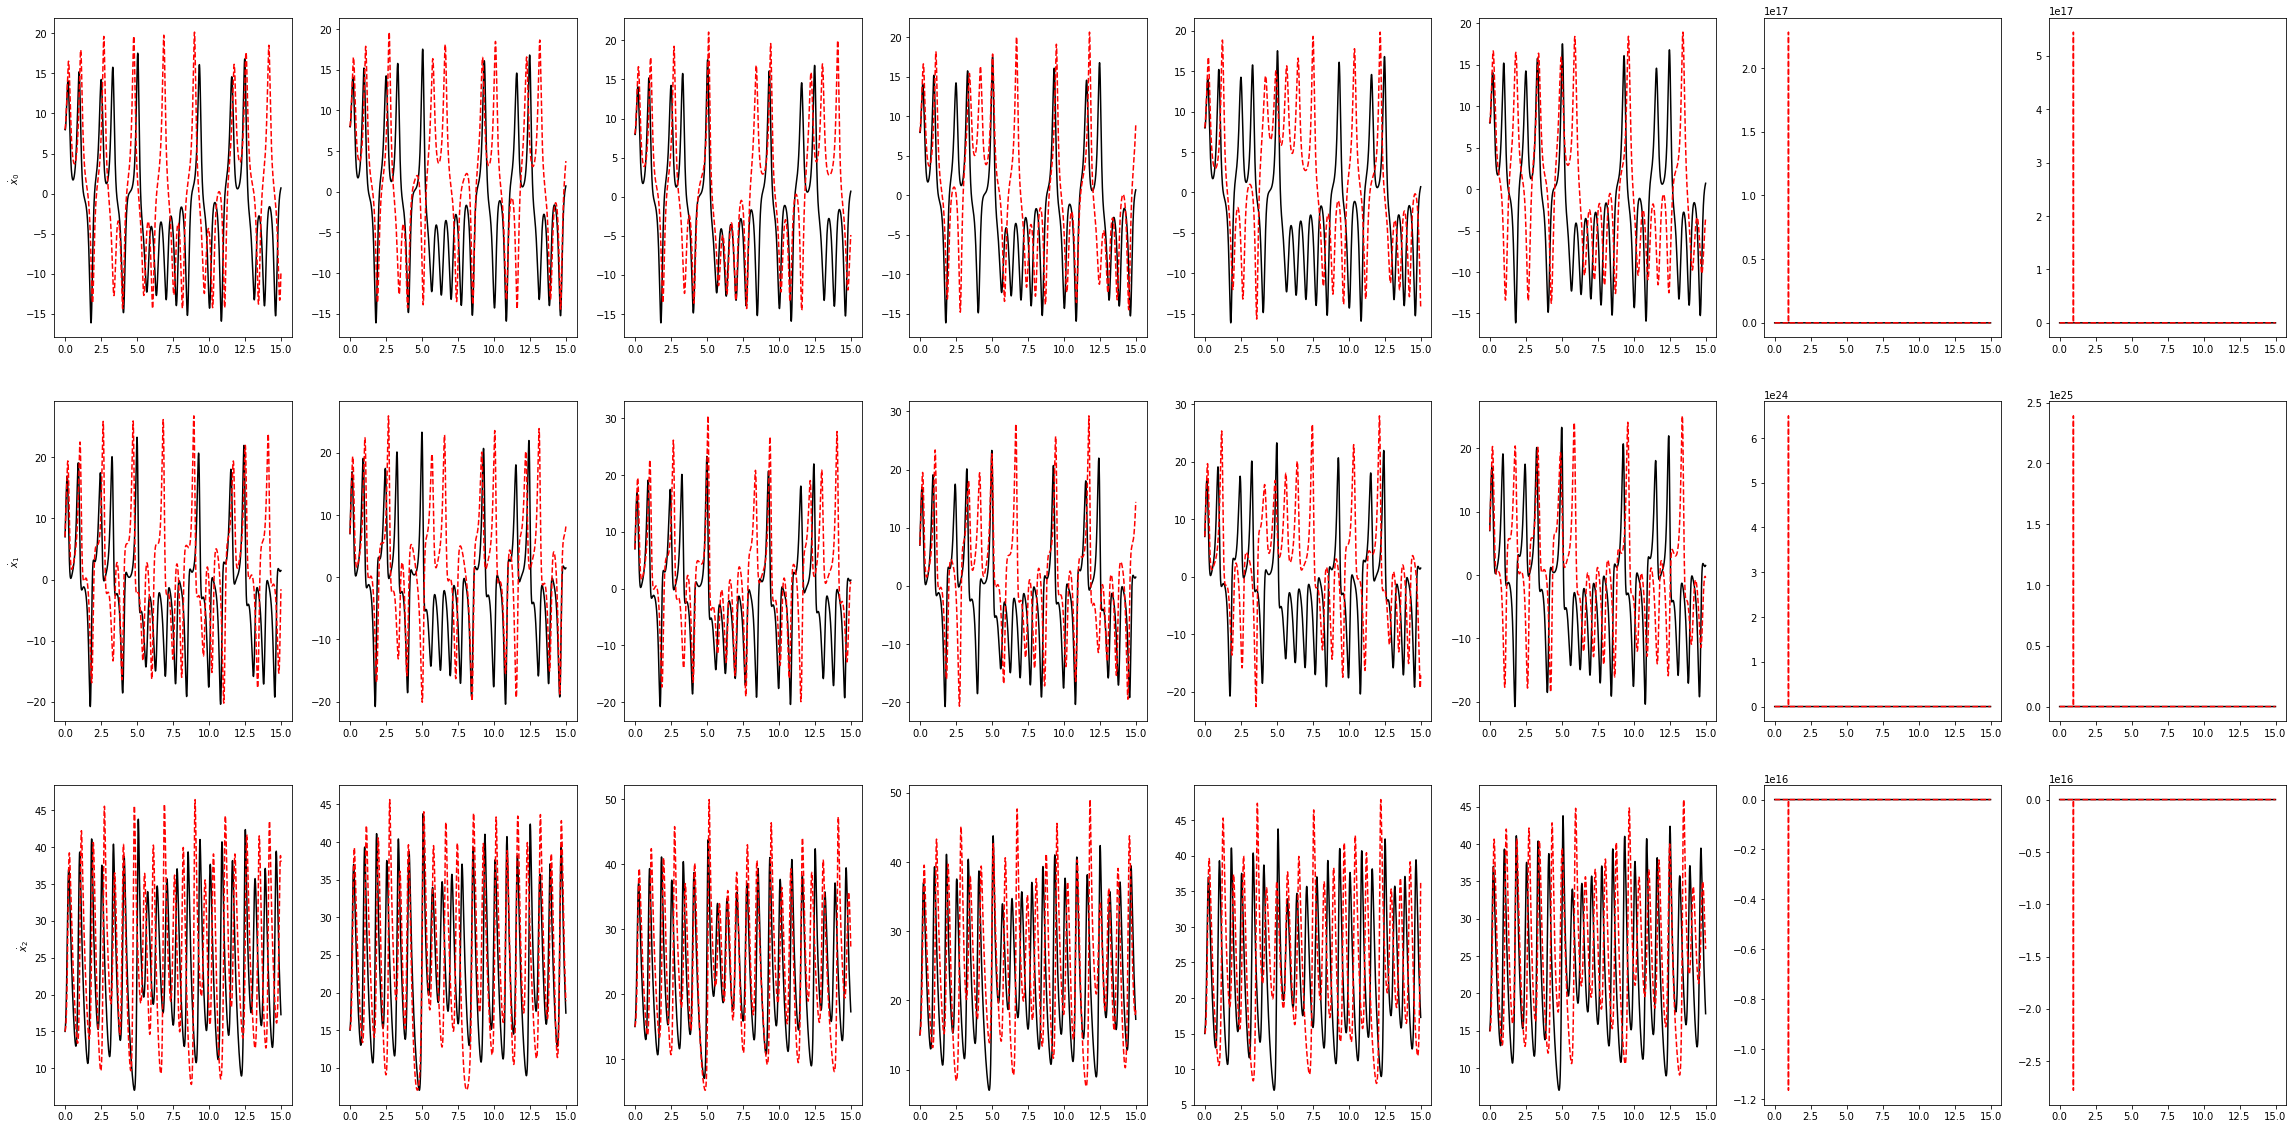

In [4]:
plt.figure(figsize=(40, 20))
for j in range(np.shape(ssr_optimizer.history_)[0]):
    ssr_optimizer.coef_ = np.asarray(ssr_optimizer.history_)[j, :, :]
    
    x_test_sim = model.simulate(x0_test, t_test)

    for i in range(x_test.shape[1]):
        plt.subplot(np.shape(x_test)[1], np.shape(ssr_optimizer.history_)[0], 
                    i * np.shape(ssr_optimizer.history_)[0] + j + 1)
        plt.plot(t_test, x_test[:, i],
                    'k', label='numerical derivative')
        plt.plot(t_test, x_test_sim[:, i],
                    'r--', label='model prediction')  
        if j == 0:
            plt.ylabel('$\dot x_{}$'.format(i))

# Repeat the exercise with the lowest model residual method

In [5]:
ssr_optimizer = ps.SSR(alpha=.05, criteria="model_residual")
model = ps.SINDy(optimizer=ssr_optimizer)
model.fit(x_train, t=dt)

SINDy(differentiation_method=FiniteDifference(),
      feature_library=PolynomialLibrary(), feature_names=['x0', 'x1', 'x2'],
      optimizer=SSR(criteria='model_residual'))

Model 0, MSE: 627.209646
Model 1, MSE: 614.266649
Model 2, MSE: 615.764781
Model 3, MSE: 634.357049
Model 4, MSE: 640.397986
Model 5, MSE: 687.854336
Model 6, MSE: 647.100512
Model 7, MSE: 627.279484


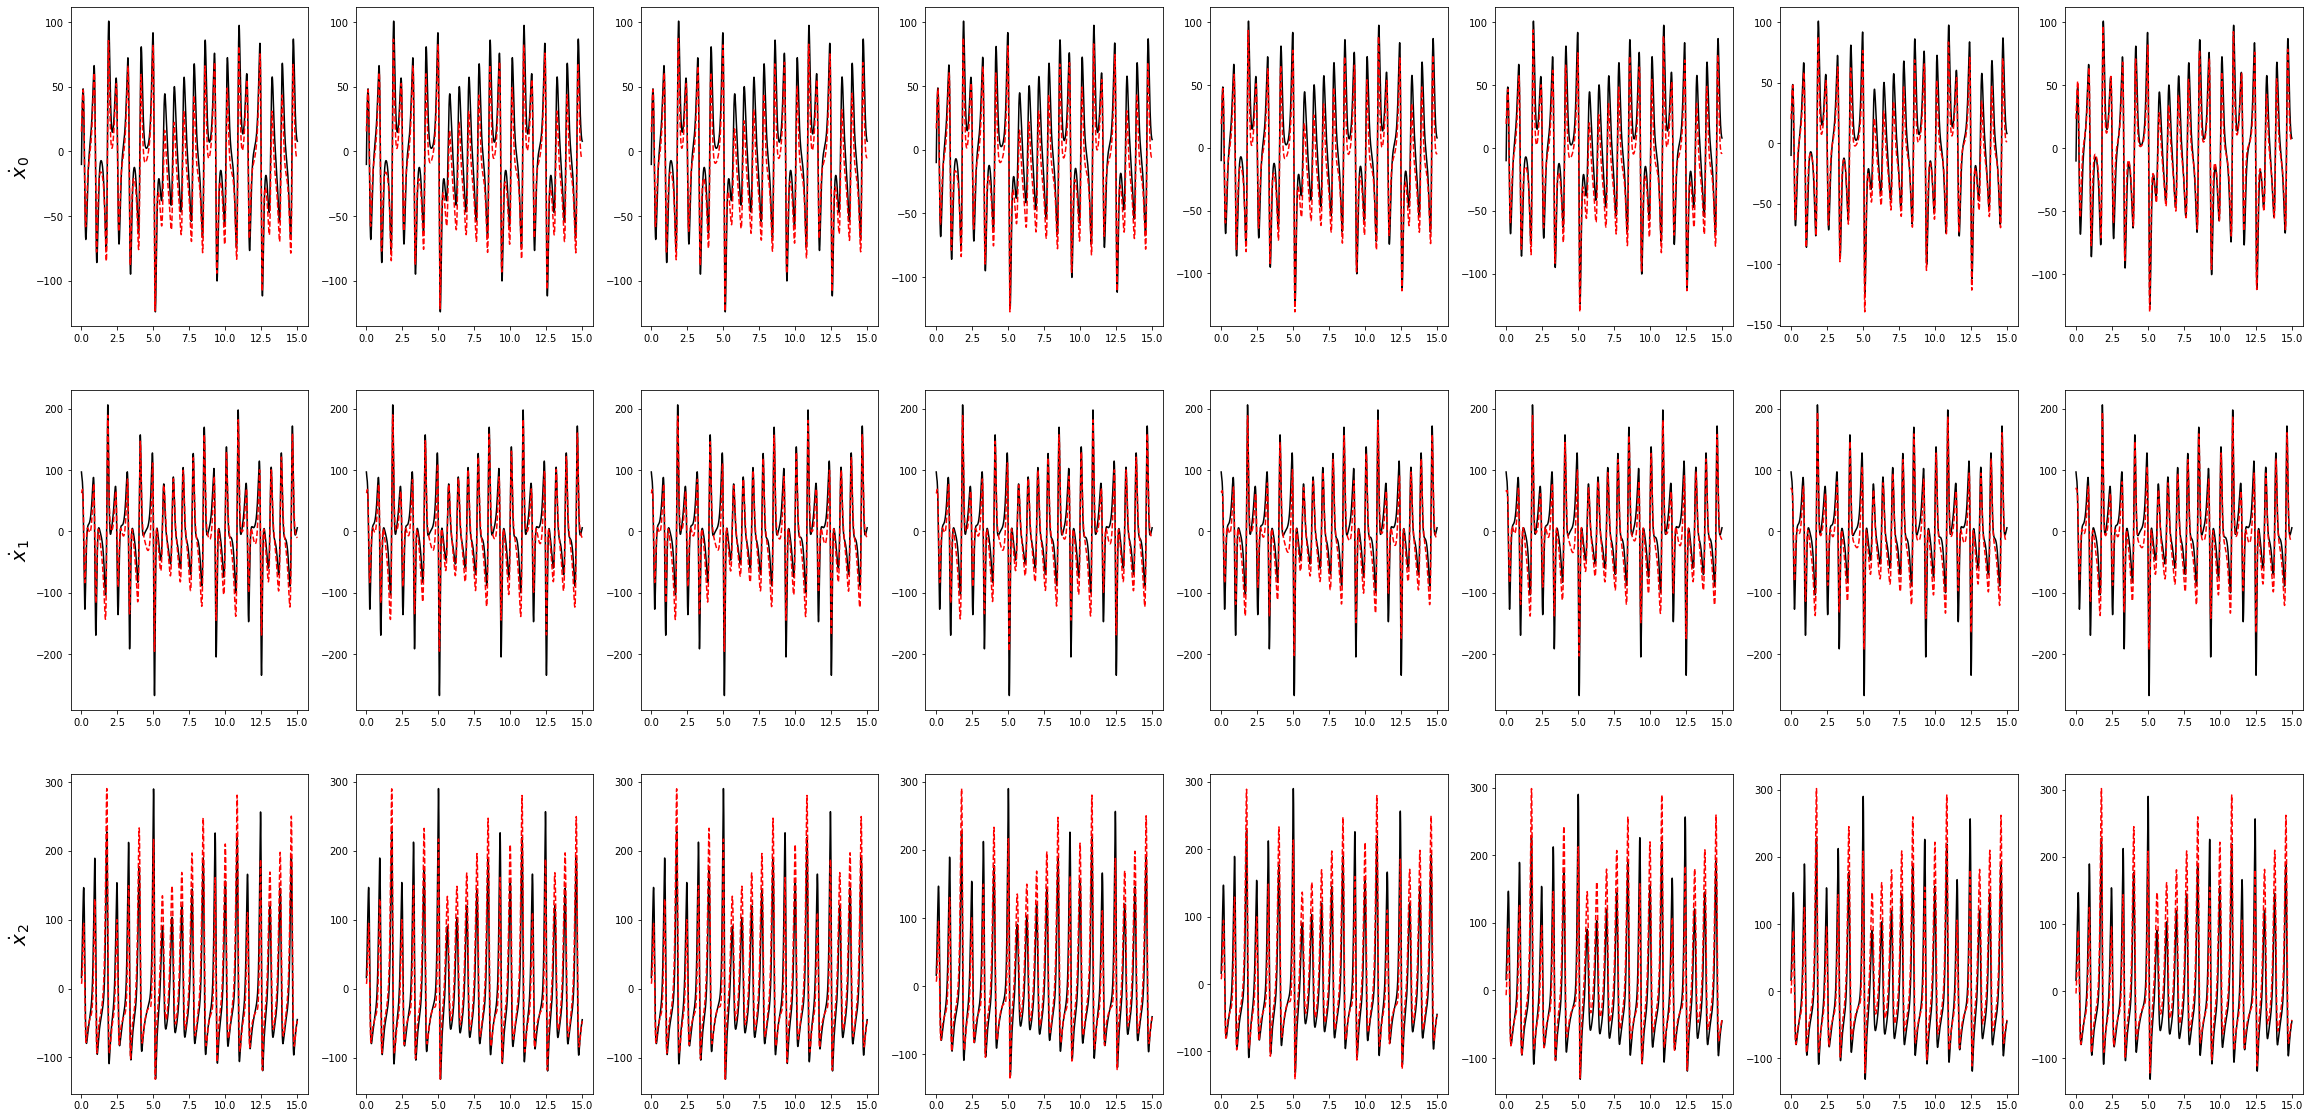

In [6]:
plt.figure(figsize=(40, 20))
for j in range(np.shape(ssr_optimizer.history_)[0]):
    ssr_optimizer.coef_ = np.asarray(ssr_optimizer.history_)[j, :, :]
    
    # Predict derivatives using the learned model
    x_dot_test_predicted = model.predict(x_test)  

    # Compute derivatives with a finite difference method, for comparison
    x_dot_test_computed = model.differentiate(x_test, t=dt)

    for i in range(x_test.shape[1]):
        plt.subplot(np.shape(x_test)[1], np.shape(ssr_optimizer.history_)[0], 
                    i * np.shape(ssr_optimizer.history_)[0] + j + 1)
        plt.plot(t_test, x_dot_test_computed[:, i],
                    'k', label='numerical derivative')
        plt.plot(t_test, x_dot_test_predicted[:, i],
                    'r--', label='model prediction')
        if j == 0:
            plt.ylabel('$\dot x_{}$'.format(i), fontsize=20)
            
    print('Model ' + str(j) + ', MSE: %f' % model.score(x_test, t=dt, metric=mean_squared_error))

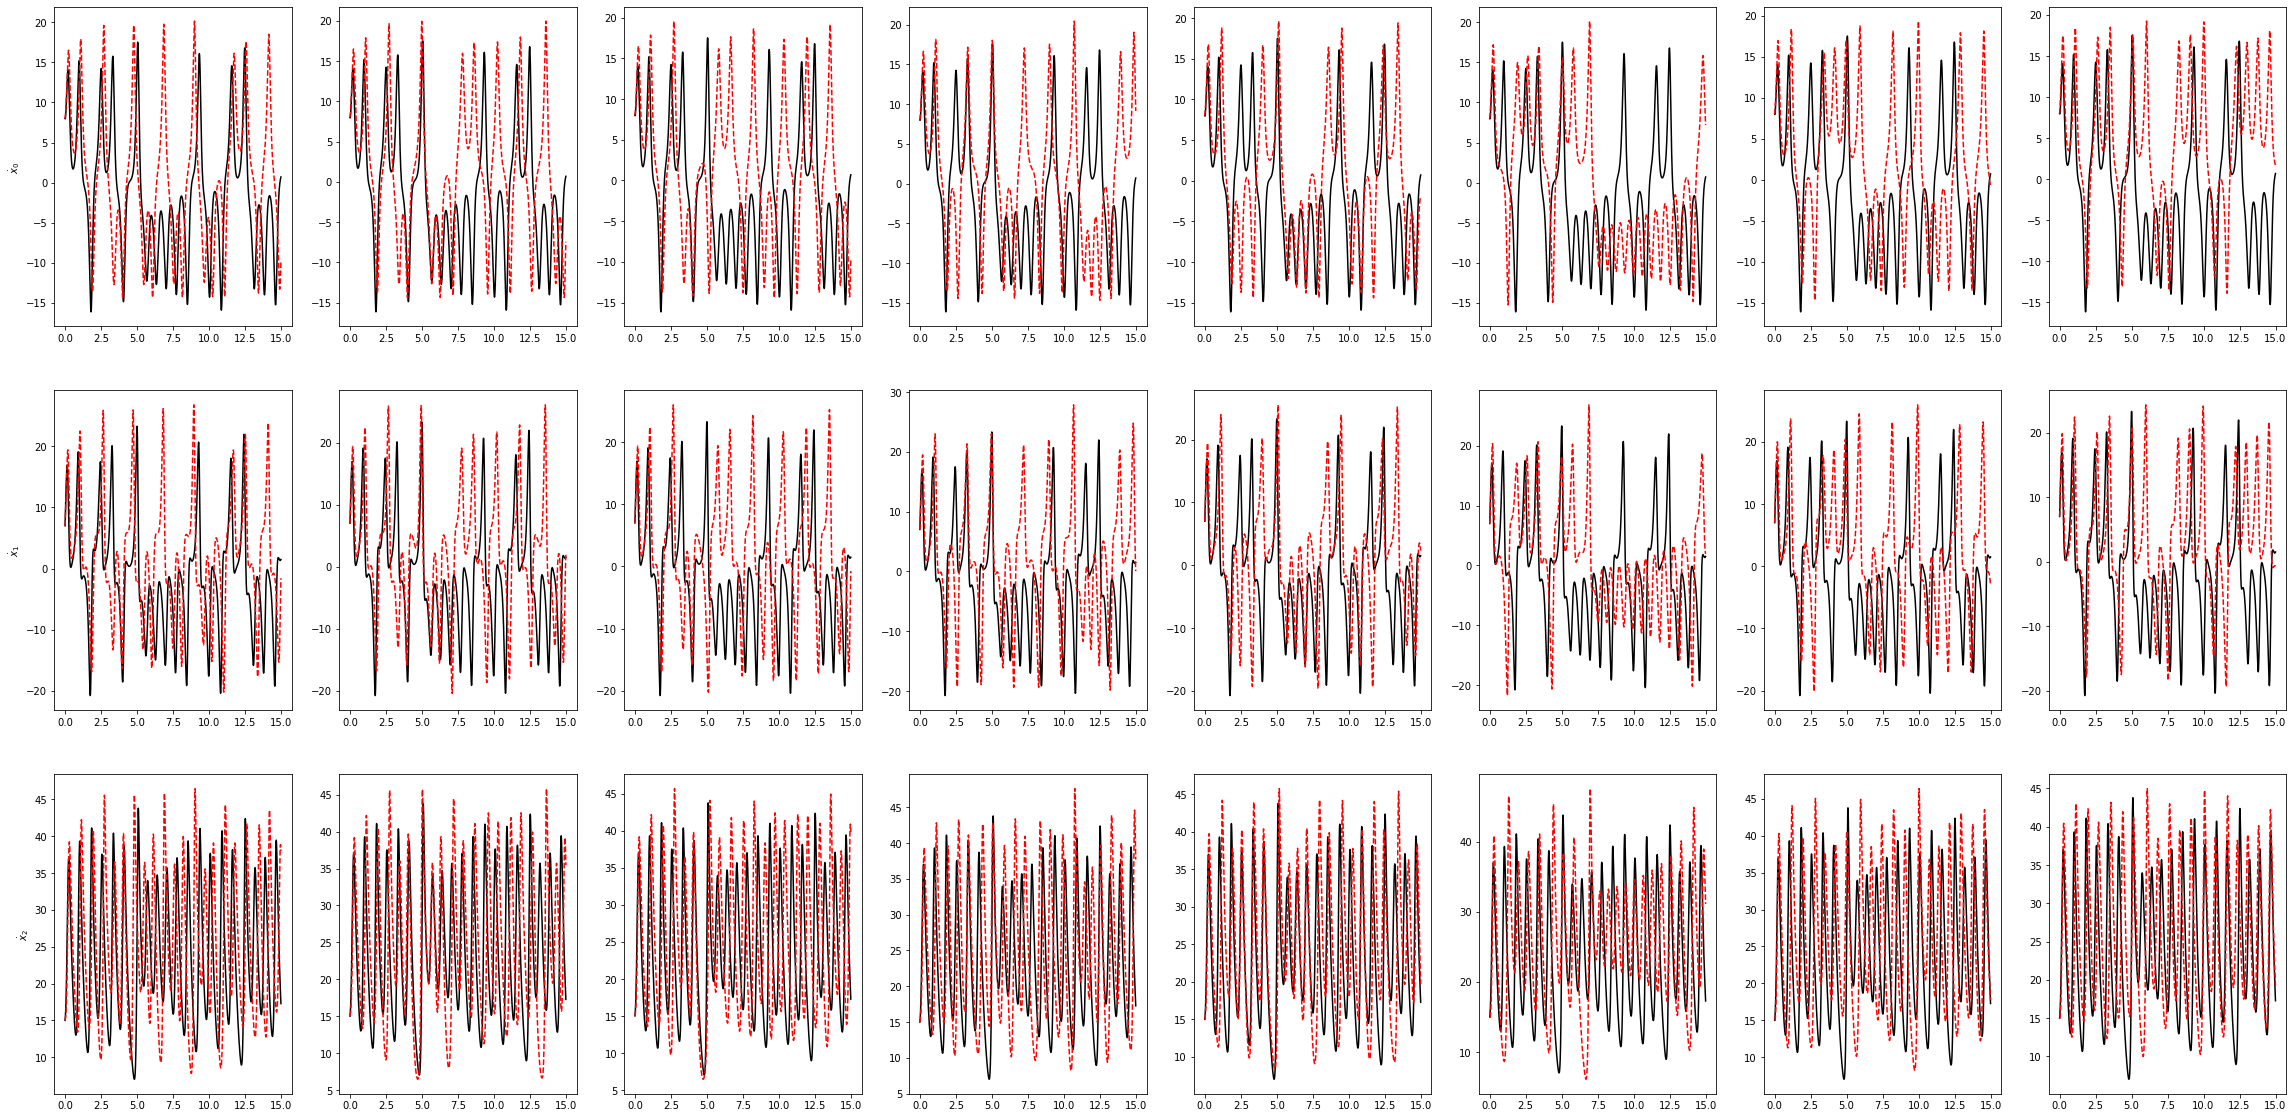

In [7]:
plt.figure(figsize=(40, 20))
for j in range(np.shape(ssr_optimizer.history_)[0]):
    ssr_optimizer.coef_ = np.asarray(ssr_optimizer.history_)[j, :, :]
    
    x_test_sim = model.simulate(x0_test, t_test)

    for i in range(x_test.shape[1]):
        plt.subplot(np.shape(x_test)[1], np.shape(ssr_optimizer.history_)[0], 
                    i * np.shape(ssr_optimizer.history_)[0] + j + 1)
        plt.plot(t_test, x_test[:, i],
                    'k', label='numerical derivative')
        plt.plot(t_test, x_test_sim[:, i],
                    'r--', label='model prediction')  
        if j == 0:
            plt.ylabel('$\dot x_{}$'.format(i))

### FROLS greedy algorithm
Forward Regression Orthogonal Least Squares (FROLS) solves the least-squares regression problem with $L_0$ norm by iteratively selecting the most correlated function in the library. At each step, the candidate functions are orthogonalized with respect to the already-selected functions. The selection criteria is the Error Reduction Ratio, i.e. the normalized increase in the explained output variance due to the addition of a given function to the basis.

In [8]:
dt = .002
t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
x_train = x_train  #+ np.random.rand(x_train.shape[0], 3) * 4
# Evolve the Lorenz equations in time using a different initial condition
t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
x_test = odeint(lorenz, x0_test, t_test)  

frols_optimizer = ps.FROLS()

model = ps.SINDy(optimizer=frols_optimizer)
model.fit(x_train, t=dt)
model.print()
coef_hist = np.asarray(frols_optimizer.history_)
for i in range(coef_hist.shape[0]):
    frols_optimizer.coef_ = coef_hist[i, :, :]
    x_dot_test_predicted = model.predict(x_test)  
    print('Model ' + str(i) + ', MSE: %f' % model.score(x_test, t=dt, metric=mean_squared_error))

x0' = -0.001 1 + -10.005 x0 + 10.003 x1
x1' = -0.010 1 + 27.990 x0 + -0.997 x1 + 0.001 x2 + -1.000 x0 x2
x2' = 0.014 1 + 0.002 x0 + -2.667 x2 + 0.001 x0^2 + 0.999 x0 x1
Model 0, MSE: 4374.241419
Model 1, MSE: 2320.468027
Model 2, MSE: 138.984570
Model 3, MSE: 103.194255
Model 4, MSE: 0.000068
Model 5, MSE: 0.000051
Model 6, MSE: 0.000055
Model 7, MSE: 0.000054
Model 8, MSE: 0.000056
Model 9, MSE: 0.000058


Model 0, MSE: 4374.241419
Model 1, MSE: 2320.468027
Model 2, MSE: 138.984570
Model 3, MSE: 103.194255
Model 4, MSE: 0.000068
Model 5, MSE: 0.000051
Model 6, MSE: 0.000055
Model 7, MSE: 0.000054
Model 8, MSE: 0.000056
Model 9, MSE: 0.000058


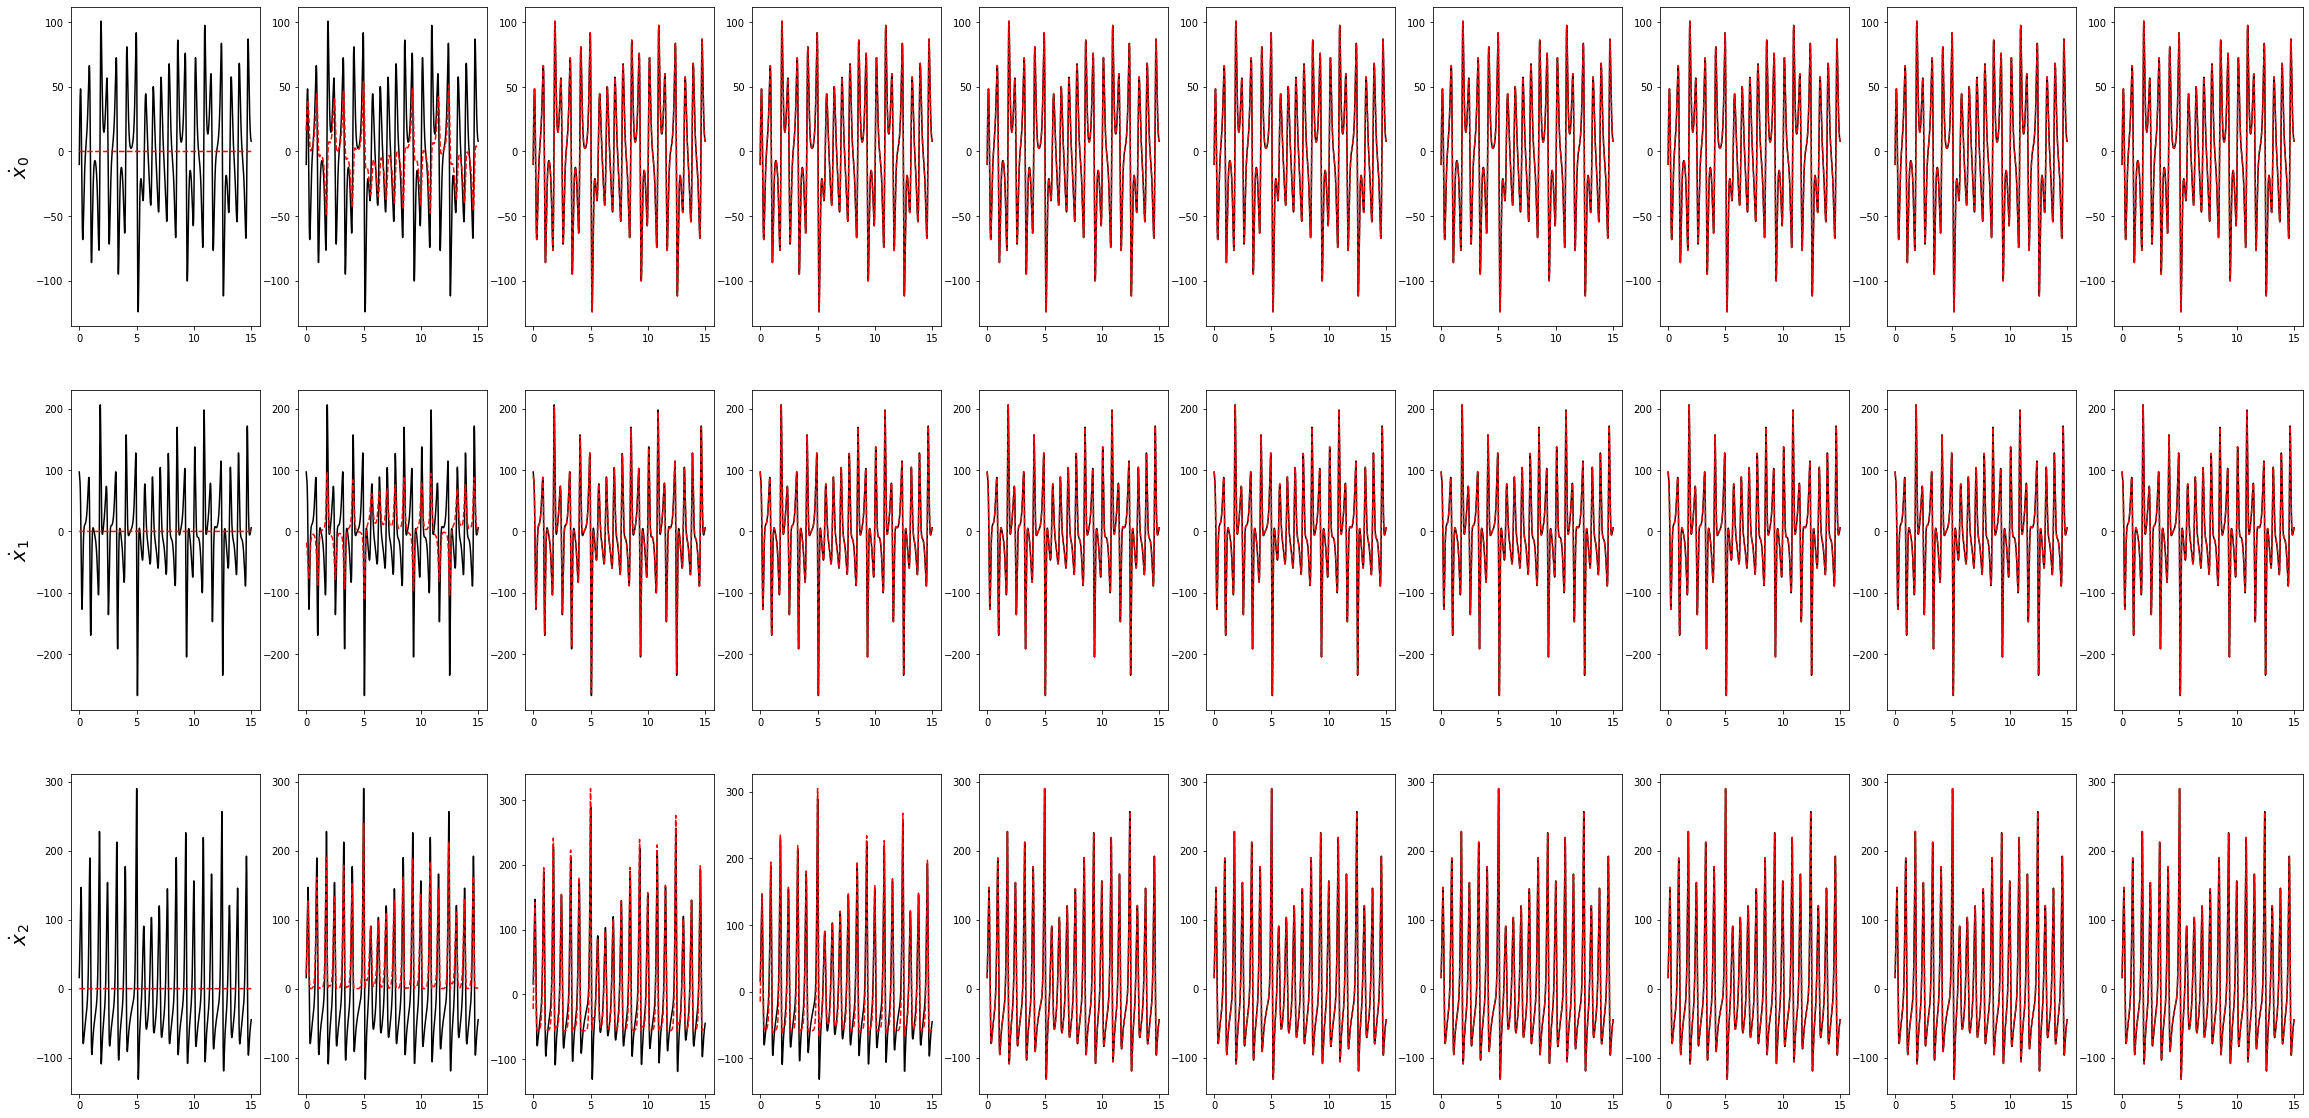

In [9]:
plt.figure(figsize=(40, 20))
coef_hist = np.asarray(frols_optimizer.history_)
for j in range(coef_hist.shape[0]):
    frols_optimizer.coef_ = coef_hist[j, :, :]
    
    # Predict derivatives using the learned model
    x_dot_test_predicted = model.predict(x_test)  

    # Compute derivatives with a finite difference method, for comparison
    x_dot_test_computed = model.differentiate(x_test, t=dt)

    for i in range(x_test.shape[1]):
        plt.subplot(np.shape(x_test)[1], coef_hist.shape[0], 
                    i * coef_hist.shape[0] + j + 1)
        plt.plot(t_test, x_dot_test_computed[:, i],
                    'k', label='numerical derivative')
        plt.plot(t_test, x_dot_test_predicted[:, i],
                    'r--', label='model prediction')
        if j == 0:
            plt.ylabel('$\dot x_{}$'.format(i), fontsize=20)
            
    print('Model ' + str(j) + ', MSE: %f' % model.score(x_test, t=dt, metric=mean_squared_error))

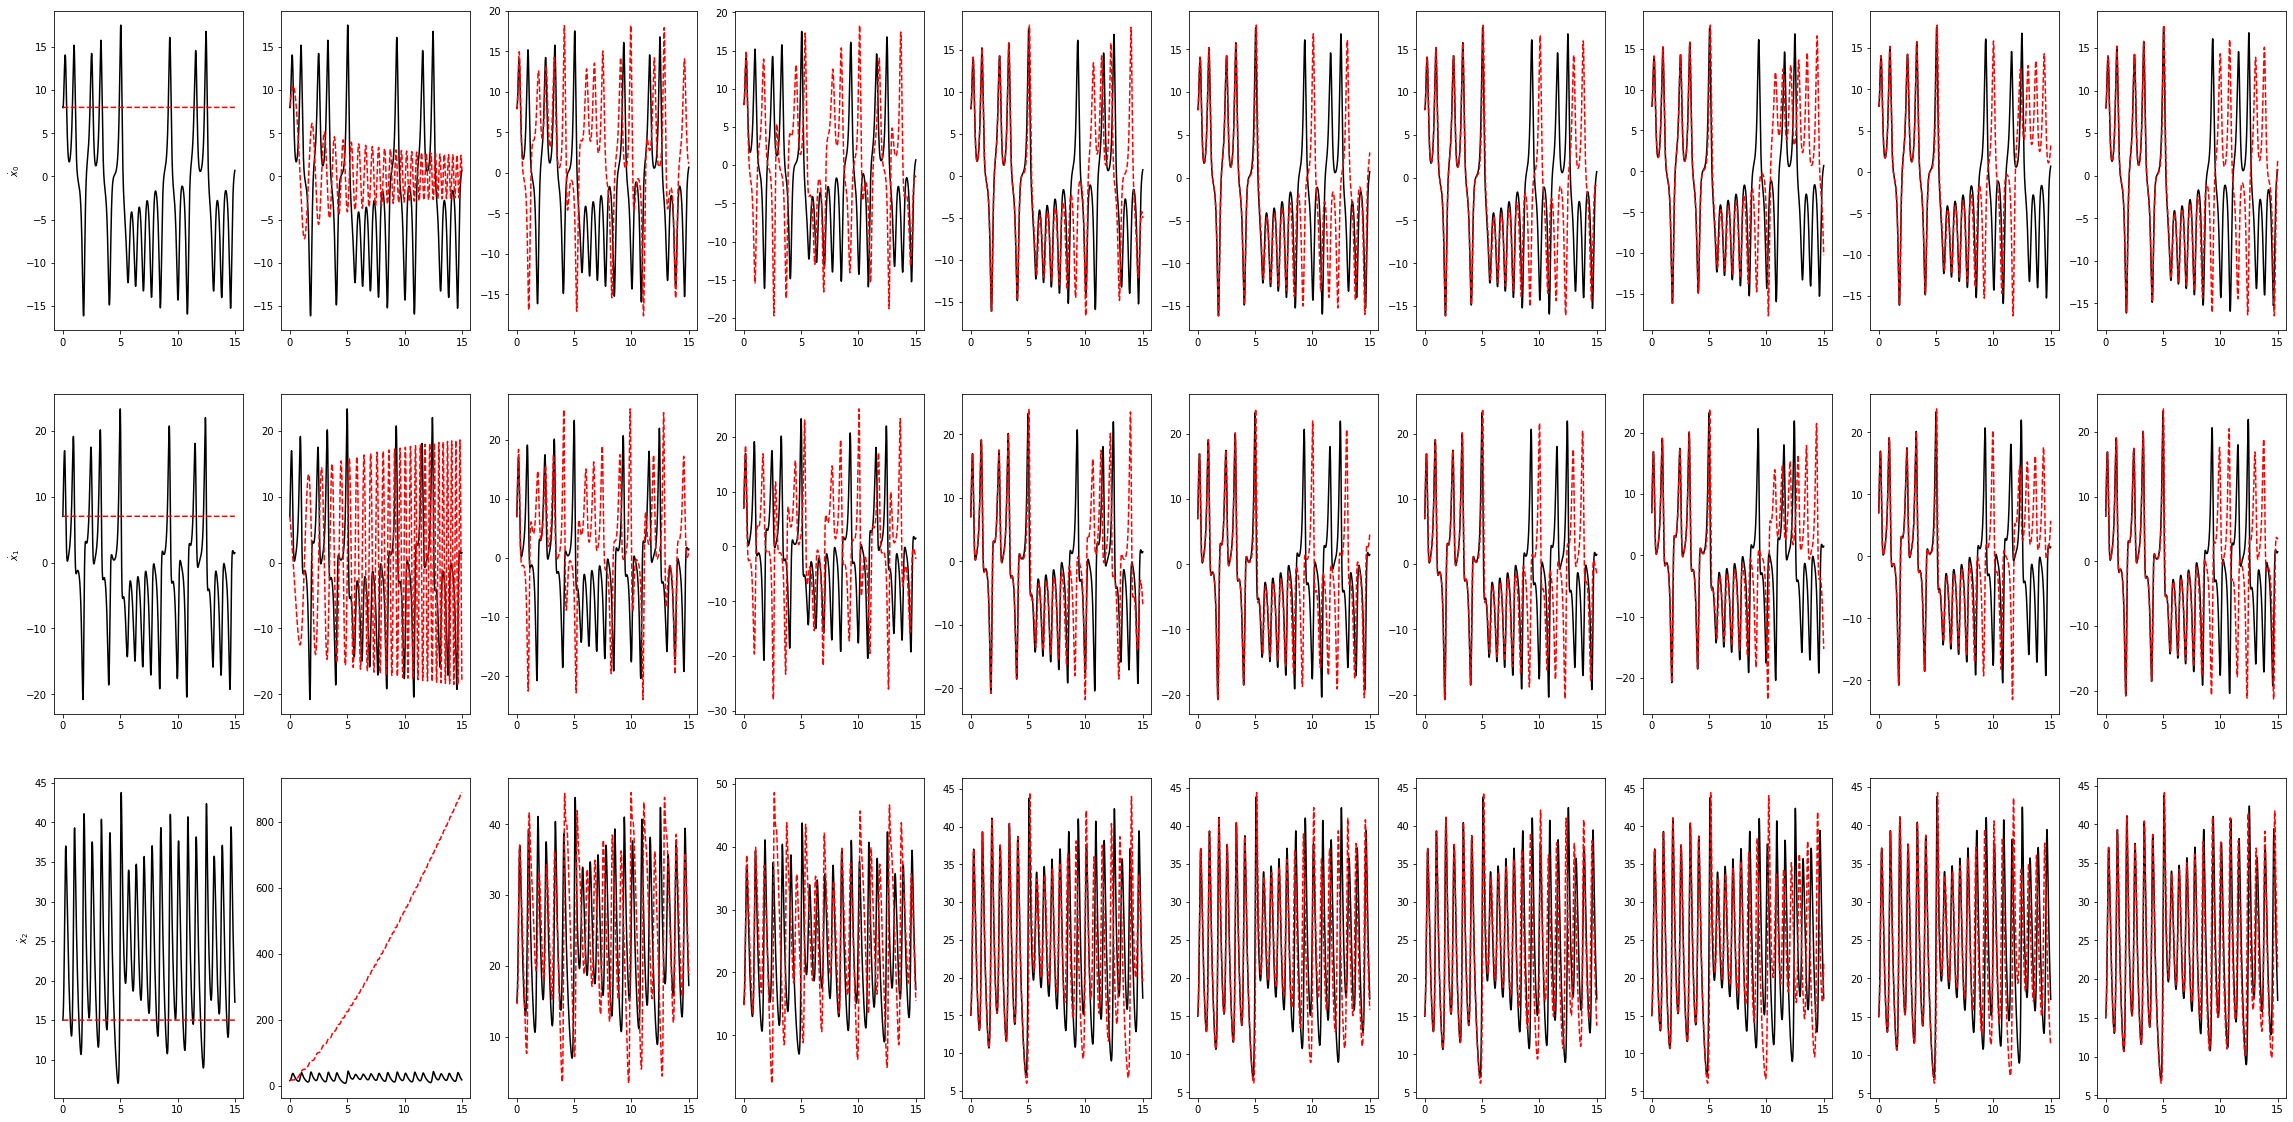

In [10]:
plt.figure(figsize=(40, 20))
coef_hist = np.asarray(frols_optimizer.history_)
for j in range(coef_hist.shape[0]):
    frols_optimizer.coef_ = coef_hist[j, :, :]
    
    x_test_sim = model.simulate(x0_test, t_test)

    for i in range(x_test.shape[1]):
        plt.subplot(np.shape(x_test)[1], coef_hist.shape[0], 
                    i * coef_hist.shape[0] + j + 1)
        plt.plot(t_test, x_test[:, i],
                    'k', label='numerical derivative')
        plt.plot(t_test, x_test_sim[:, i],
                    'r--', label='model prediction')  
        if j == 0:
            plt.ylabel('$\dot x_{}$'.format(i))

# Let's compare all three methods as the noise steadily increases, cross-validated over 20 noise instantiations

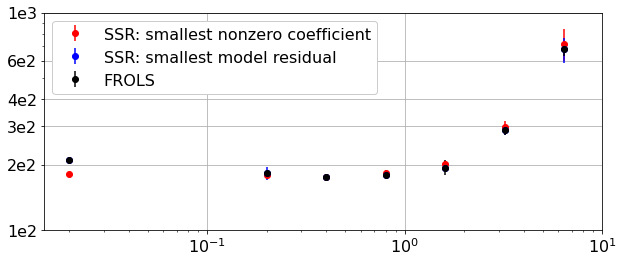

In [11]:
dt = .1
t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27]
x_train = odeint(lorenz, x0_train, t_train)
ssr_optimizer = ps.SSR(alpha=.05)
model = ps.SINDy(optimizer=ssr_optimizer)

t_test = np.arange(0, 15, dt)
x0_test = np.array([8, 7, 15])
x_test = odeint(lorenz, x0_test, t_test)  

n_validation = 10
noise_levels = [0.02, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4]
criterias = ["coefficient_value", "model_residual"]
final_MSE = np.zeros((3, len(noise_levels), n_validation))
for k, noise_level in enumerate(noise_levels):
    for i in range(n_validation):
        x_noisy = x_train + np.random.rand(x_train.shape[0], 3) * noise_level
        for kk in range(3): 
            if kk == 0:
                optimizer = ps.SSR(alpha=0, criteria="coefficient_value")
            if kk == 1:
                optimizer = ps.SSR(alpha=0, criteria="model_residual")
            if kk == 2:
                optimizer = ps.FROLS()
            model = ps.SINDy(optimizer=optimizer)
            model.fit(x_noisy, t=dt)
            MSE = np.zeros(np.shape(optimizer.history_)[0])
            for j in range(np.shape(optimizer.history_)[0]):
                optimizer.coef_ = np.asarray(optimizer.history_)[j, :, :]
                MSE[j] = model.score(x_test, t=dt, metric=mean_squared_error)
            final_MSE[kk, k, i] = np.min(MSE)
            
average_MSE_cross_validated = np.mean(final_MSE, axis=-1)
std_MSE_cross_validated = np.std(final_MSE, axis=-1)
plt.figure(figsize=(10, 4))
plt.errorbar(noise_levels, average_MSE_cross_validated[0, :], 
             yerr=std_MSE_cross_validated[0, :], fmt='o', color='r', 
             label='SSR: smallest nonzero coefficient')
plt.errorbar(noise_levels, average_MSE_cross_validated[1, :], 
             yerr=std_MSE_cross_validated[1, :], fmt='o', color='b',
             label='SSR: smallest model residual')
plt.errorbar(noise_levels, average_MSE_cross_validated[1, :], 
             yerr=std_MSE_cross_validated[2, :], fmt='o', color='k',
             label='FROLS')
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=16, loc='upper left', framealpha=1.0)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
ax = plt.gca()
ax.set_xticks([0.1, 1.0, 10])
ax.set_yticks([1e2, 2e2, 3e2, 4e2, 6e2, 10e2])
ax.set_yticklabels(['1e2', '2e2', '3e2', '4e2', '6e2', '1e3'])
plt.savefig('SSR_FROLS_comparison.pdf')